In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import RFE
import numpy as np
import utils
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

In [2]:
data = pd.read_csv('Data/Post_Visualization_10-16.csv')

# Data Preprocessing

I am creating the training data set here. I am holding out only 5% of the data for testing. I think that 5% will be enough considering the cleaned data contains 696,781 observations. This will allow for 34,839 observations to be used as test data, which seems like plenty.

In [3]:
X_train, X_test = train_test_split(data, test_size = 0.05,random_state=10082020)

In [ ]:
#now to standardize the 'Age', 'New Age', and 'Total Factors' features on the training set
#this must be done first because this will change the interactions and it's easier to scale three features then
#three * 18 other features.
std_scaler = StandardScaler()
std_scaler.fit(X_train[['Age','New Age','Total Factors']])
X_train.loc[:,['Age','New Age','Total Factors']] = std_scaler.transform(X_train[['Age','New Age','Total Factors']])
X_test.loc[:,['Age','New Age','Total Factors']] = std_scaler.transform(X_test[['Age','New Age','Total Factors']])

In [ ]:
# First I need to encode the features
enc = OneHotEncoder()
enc.fit(X_train[['Entity of Residence Grouped','Sex']])
encoded = enc.transform(X_train[['Entity of Residence Grouped','Sex']]).toarray()
X_train[list(enc.get_feature_names(['Entity Group','Sex']))] = encoded
del X_train['Sex']
del X_train['Entity of Residence Grouped']

#do the same for the testing data
encoded = enc.transform(X_test[['Entity of Residence Grouped','Sex']]).toarray()
X_test[list(enc.get_feature_names(['Entity Group','Sex']))] = encoded
del X_test['Sex']
del X_test['Entity of Residence Grouped']

In [6]:
#Then I need to create the interaction terms. In order to keep the number of interactions down, I'm only doing degree of 2
cols = list(X_train.columns)
cols.remove('Died')
cols.remove('Age')
cols.remove('Entity Group_1')
cols.remove('Entity Group_2')
cols.remove('Entity Group_3')

poly_features = PolynomialFeatures(degree=2, interaction_only=True)
poly_features.fit(X_train[cols])
interactions_data = poly_features.transform(X_train[cols])
interactions_data_test = poly_features.transform(X_test[cols])
interaction_names = poly_features.get_feature_names(cols)

In [7]:
#There are 137 different possibilities if considering all interactions. This is not feasible, so
#I only want to keep the best interactions (the ones with correlation of 0.26 or higher with the 'Died' feature)
high_cor_interactions = ['Pneumonia New Age','Pneumonia Total Factors','New Age Total Factors','Pneumonia Sex_2',
                         'Pneumonia Hypertension', 'Pneumonia Diabetes', 'Total Factors Sex_2','Hypertension Total Factors',
                        'Diabetes Total Factors','Hypertension New Age']

In [ ]:
#adding only the interactions in the list above to the data set
for i in range(len(interaction_names)):
    if interaction_names[i] in high_cor_interactions:
        X_train[interaction_names[i]] = interactions_data[:,i]
        X_test[interaction_names[i]] = interactions_data_test[:,i]

In [9]:
#now to check to make sure the structures of the training data and test data are the same in terms of the columns
list(X_train.columns) == list(X_test.columns)

True

Assigning the target variable to y, and the rest of the variables to X.

In [10]:
p_variables = list(X_train.columns)
p_variables.remove('Died')
#removing Age because we have New Age, but I don't want to take Age out of the data in case at some point it needs to go back
p_variables.remove('Age')
X = X_train[p_variables]
y = X_train['Died']
X_t = X_test[p_variables]
y_t = X_test['Died']

# Preprocessing Done - Time to do Modelling!!

### Base Classification

First, I'd like to see what sort of accuracy could be acheived by a dummy classifier (giving every observation the same prediction).

In [127]:
print("Base Accuracy is "+str(1-sum(data['Died'])/len(data['Died'])))

Base Accuracy is 0.8947459818795289


## Logistic Regression

### Performing Forward Stepwise Selection of Variables

In [ ]:
log_model = LogisticRegression(penalty = 'none', max_iter= 10000)
features, factors = utils.forwardSelection(X,y,log_model,'Rate')

Below shows performing 5-fold cross validation for each model and the resulting estimated test accuracy for each model.

In [ ]:
#The below is doing cross validation (5-fold) on the models selected at each step of forward stepwise selection
all_metrics = utils.performValidations(X,y,features[1:],5,log_model)

In [28]:
#using the utils function to get the precision, recall, and accuracy for each model
fwd_precision, fwd_recall, fwd_acc = utils.getMetricSummaries(all_metrics)

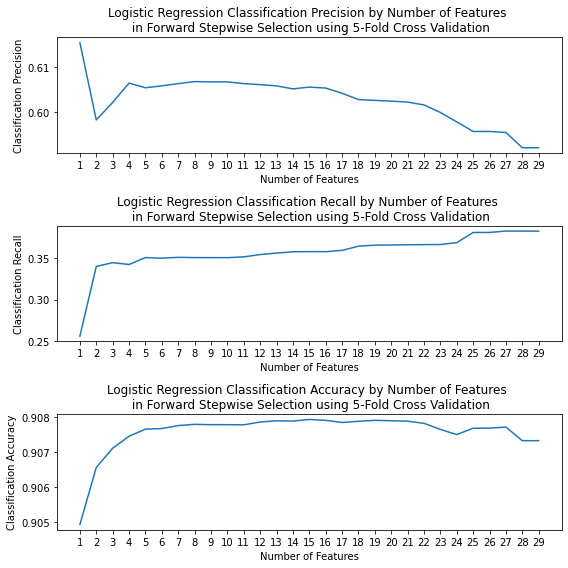

In [29]:
#plotting the precision, recall, and accuracy as a function of the model complexity
fig, ax = plt.subplots(3,1)
fig.set_size_inches(8, 8)
ax[0].plot(np.arange(1,30,1),fwd_precision)
ax[0].set_title("Logistic Regression Classification Precision by Number of Features \n in Forward Stepwise Selection using 5-Fold Cross Validation")
ax[0].set_xlabel("Number of Features")
ax[0].set_ylabel("Classification Precision")
ax[0].set_xticks(np.arange(1,30,1))
ax[1].plot(np.arange(1,30,1),fwd_recall)
ax[1].set_title("Logistic Regression Classification Recall by Number of Features \n in Forward Stepwise Selection using 5-Fold Cross Validation")
ax[1].set_xlabel("Number of Features")
ax[1].set_ylabel("Classification Recall")
ax[1].set_xticks(np.arange(1,30,1))
ax[2].plot(np.arange(1,30,1),fwd_acc)
ax[2].set_title("Logistic Regression Classification Accuracy by Number of Features \n in Forward Stepwise Selection using 5-Fold Cross Validation")
ax[2].set_xlabel("Number of Features")
ax[2].set_ylabel("Classification Accuracy")
ax[2].set_xticks(np.arange(1,30,1))
fig.tight_layout()
plt.savefig('Forward Selection Metrics.png')

The test metrics found using cross validation suggest that the precision, and recall are nearly maximized while only using 5 features. The model using 5 features is shown below.

In [30]:
log_model = LogisticRegression(penalty = 'none', max_iter= 10000)
log_model.fit(X[features[5]],y)

LogisticRegression(max_iter=10000, penalty='none')

In [31]:
#creating a dataframe fro the 5 feature model for visual purposes
fwd_5_df = pd.DataFrame({'Features':features[5],'Coefficients':log_model.coef_[0]})
fwd_5_df

,Features,Coefficients
0,Pneumonia New Age,0.667197
1,Pneumonia,2.137625
2,Kidney Failure,1.214972
3,Pneumonia Sex_2,0.333747
4,Pneumonia Total Factors,0.121695


In [32]:
print("Accuracy is "+str(fwd_acc[4]))
print("Precision is "+str(fwd_precision[4]))
print("Recall is "+str(fwd_recall[4]))

Accuracy is 0.9076624653858879
Precision is 0.6054413333002654
Recall is 0.35062118491921007


The above model includes interaction features. It is usually good practice to include the underlying features of any interaction terms in the model. Therefore, I will add New Age, Sex_2, and Total Factors to this model.

In [33]:
chosen_fwd_features = list(features[5])
chosen_fwd_features.append('New Age')
chosen_fwd_features.append('Sex_2')
chosen_fwd_features.append('Total Factors')
log_model.fit(X[chosen_fwd_features],y)
fwd_full_df = pd.DataFrame({'Features':chosen_fwd_features,'Coefficients':log_model.coef_[0]})
fwd_full_df

,Features,Coefficients
0,Pneumonia New Age,-0.477297
1,Pneumonia,2.983048
2,Kidney Failure,0.588276
3,Pneumonia Sex_2,-0.316935
4,Pneumonia Total Factors,-0.262173
5,New Age,1.131943
6,Sex_2,0.655208
7,Total Factors,0.427088


In [34]:
fwd_model_metrics = utils.performValidations(X,y,[chosen_fwd_features],5,log_model)
fwd_final_precision, fwd_final_recall, fwd_final_acc = utils.getMetricSummaries(fwd_model_metrics)
print("Accuracy is "+str(fwd_final_acc[0]))
print("Precision is "+str(fwd_final_precision[0]))
print("Recall is "+str(fwd_final_recall[0]))

1 of 1
Accuracy is 0.9072424883788737
Precision is 0.5977839598639941
Recall is 0.3610915619389587


Adding in the original terms to accompany the interactions have raised the recall from ~35% to ~36%.

## Performing Backward Stepwise Selection of Variables

The below cell performs the backward selection, but only one step at a time instead of doing all the steps in one line of code. This cell captures the models at each step.

In [ ]:
log_model = LogisticRegression(penalty = 'none', max_iter= 10000)
variables = list(X.columns)
v_len = len(variables)
models = [[]]
for i in range(v_len):
    print(i)
    selector2 = RFE(log_model,n_features_to_select=v_len-i,step=1)
    selector2 = selector2.fit(X[variables],y)
    variables = list(pd.Series(variables)[selector2.support_])
    models.append(variables)

The cell below uses the models created along each step of backward selection and does 5-Fold cross validation and records the mean accuracy for each model over the 5-folds.

In [ ]:
#First I need to reverse the order of the models so that when graphing later on, the number of features is ascending rather
#than descending, and then do the cross validations
bwd_models = list(models[1:])
bwd_models.reverse()
log_model = LogisticRegression(penalty = 'none', max_iter= 10000)
back_metrics = utils.performValidations(X,y,bwd_models,5,log_model)

In [35]:
#getting the metric summaries for each models cross validation
bwd_precision, bwd_recall, bwd_acc = utils.getMetricSummaries(back_metrics)

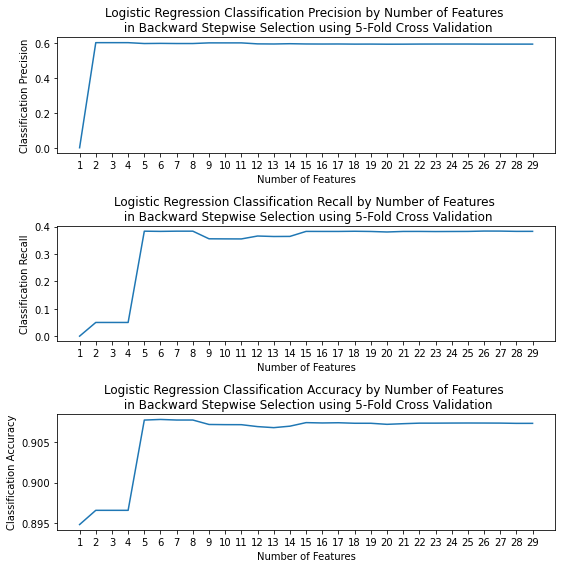

In [36]:
#plotting the metrics
fig, ax = plt.subplots(3,1)
fig.set_size_inches(8, 8)
ax[0].plot(np.arange(1,30,1),bwd_precision)
ax[0].set_title("Logistic Regression Classification Precision by Number of Features \n in Backward Stepwise Selection using 5-Fold Cross Validation")
ax[0].set_xlabel("Number of Features")
ax[0].set_ylabel("Classification Precision")
ax[0].set_xticks(np.arange(1,30,1))
ax[1].plot(np.arange(1,30,1),bwd_recall)
ax[1].set_title("Logistic Regression Classification Recall by Number of Features \n in Backward Stepwise Selection using 5-Fold Cross Validation")
ax[1].set_xlabel("Number of Features")
ax[1].set_ylabel("Classification Recall")
ax[1].set_xticks(np.arange(1,30,1))
ax[2].plot(np.arange(1,30,1),bwd_acc)
ax[2].set_title("Logistic Regression Classification Accuracy by Number of Features \n in Backward Stepwise Selection using 5-Fold Cross Validation")
ax[2].set_xlabel("Number of Features")
ax[2].set_ylabel("Classification Accuracy")
ax[2].set_xticks(np.arange(1,30,1))
fig.tight_layout()
plt.savefig('Backward Selection Metrics.png')

These graphs show that taking out the majority of the features doesn't impact the precision, recall or accuracy of the model. However, after leaving less than 5 features in the model, theses metrics plummit. Therefore, using a model with 5 features appears best for the backward selection model of choice. This model can be seen below.

Very interestingly, this model doesn't contain any interaction terms! The model details can seen below.

In [38]:
log_model.fit(X[bwd_models[4]],y)
bwd_df = pd.DataFrame({'Features':bwd_models[4],'Coefficients':log_model.coef_[0]})
print("\nPrecision is "+str(bwd_precision[4]))
print("Recall is "+str(bwd_recall[4]))
print("Accuracy is "+str(bwd_acc[4]))
bwd_df


Precision is 0.5954810332894237
Recall is 0.3830664272890485
Accuracy is 0.9077380008188041


,Features,Coefficients
0,Pneumonia,2.498118
1,Kidney Failure,1.132058
2,New Age,0.941551
3,Sex_1,-1.439251
4,Sex_2,-1.008705


## Performing L2 Regularization

In [ ]:
coefficients = []
l2_metrics = []
#I want to loop through a range of values with a broad step of 2, and if there appears to be a place where I need
#a higher granularity I will approach only a small section with the small granularity instead of the whole region
for c in np.arange(-8,2,0.5):
    print(c)
    log_l2_model = LogisticRegression(penalty = 'l2', max_iter= 10000,C=10**c)
    l2_metric = utils.performValidations(X,y,[list(X.columns)],5,log_l2_model)
    l2_metrics.append(l2_metric[0])
    log_l2_model.fit(X,y)
    coefficients.append(log_l2_model.coef_)

In [65]:
coefficient_pair = pd.DataFrame({'Feature':X.columns,'Coefficients (C ~ 0.003)':coefficients[11][0],'Coefficients (C = 0)':coefficients[16][0]})
coefficient_pair

,Feature,Coefficients (C ~ 0.003),Coefficients (C = 0)
0,Pneumonia,2.105180,2.321411
1,Pregnant,0.000833,-0.017895
2,Diabetes,0.084525,-0.060466
3,COPD Diagnosis,-0.157372,-0.353562
4,Asthma,-0.497949,-0.794539
5,Immunosuppression,-0.180880,-0.396796
6,Hypertension,-0.161812,-0.324149
7,Other Diseases,0.013756,-0.129136
8,Cardiovascular Disease,-0.320327,-0.547074
9,Obesity,-0.226713,-0.380641


In [46]:
#these are the specific coefficients I want to show in a plot and explore as a function of C
pneumonia_coefs = []
Diabetes_coefs = []
COPD_coefs = []
Asthma_coefs = []
immunosuppression_coefs = []
hypertension_coefs = []
others_coefs = []
cardio_coefs = []
obesity_coefs = []
age_coefs = []
total_factors_coefs = []
entity_3_coefs = []
sex_2_coefs = []
for item in coefficients:
    pneumonia_coefs.append(item[0][0])
    Diabetes_coefs.append(item[0][2])
    COPD_coefs.append(item[0][3])
    Asthma_coefs.append(item[0][4])
    immunosuppression_coefs.append(item[0][5])
    hypertension_coefs.append(item[0][6])
    others_coefs.append(item[0][7])
    cardio_coefs.append(item[0][8])
    obesity_coefs.append(item[0][9])
    age_coefs.append(item[0][12])
    total_factors_coefs.append(item[0][13])
    entity_3_coefs.append(item[0][16])
    sex_2_coefs.append(item[0][18])

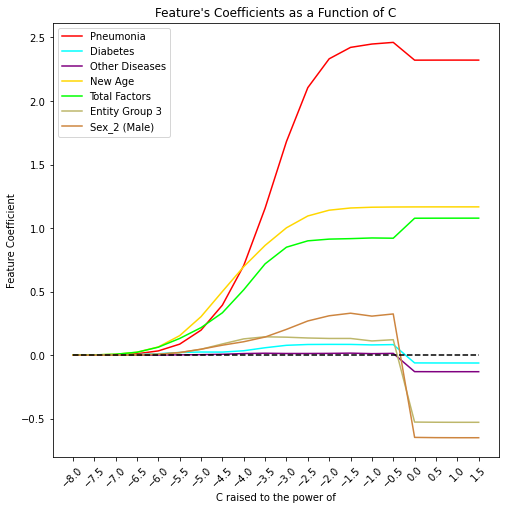

In [64]:
fig,ax=plt.subplots(1)
fig.set_size_inches(8, 8)
ax.plot(np.arange(-8,2,0.5),pneumonia_coefs,color='red',label='Pneumonia')
ax.plot(np.arange(-8,2,0.5),Diabetes_coefs,color='aqua',label='Diabetes')
#ax.plot(np.arange(-8,2,0.5),COPD_coefs,color='green',label='COPD')
#ax.plot(np.arange(-8,2,0.5),Asthma_coefs,color='blue',label='Asthma')
#ax.plot(np.arange(-8,2,0.5),immunosuppression_coefs,color='orange',label='Immunosuppression')
#ax.plot(np.arange(-8,2,0.5),hypertension_coefs,color='purple',label='Hypertension')
ax.plot(np.arange(-8,2,0.5),others_coefs,color='purple',label='Other Diseases')
#ax.plot(np.arange(-8,2,0.5),cardio_coefs,color='pink',label='Cardiovascular Disease')
#ax.plot(np.arange(-8,2,0.5),obesity_coefs,color='lightcoral',label='Obesity')
ax.plot(np.arange(-8,2,0.5),age_coefs,color='gold',label='New Age')
ax.plot(np.arange(-8,2,0.5),total_factors_coefs,color='lime',label='Total Factors')
ax.plot(np.arange(-8,2,0.5),entity_3_coefs,color='darkkhaki',label='Entity Group 3')
ax.plot(np.arange(-8,2,0.5),sex_2_coefs,color='peru',label='Sex_2 (Male)')
ax.plot([-8,1.5],[0,0],'k--')

ax.set_xlabel("C raised to the power of")
ax.set_ylabel("Feature Coefficient")
ax.set_title("Feature's Coefficients as a Function of C")
ax.legend()
ax.set_xticks(np.arange(-8,2,0.5))
plt.xticks(rotation=45)

#fig.savefig('Regularization Coefficients.png')

In [60]:
#getting the summary metrics
l2_precision, l2_recall, l2_acc = utils.getMetricSummaries(l2_metrics)

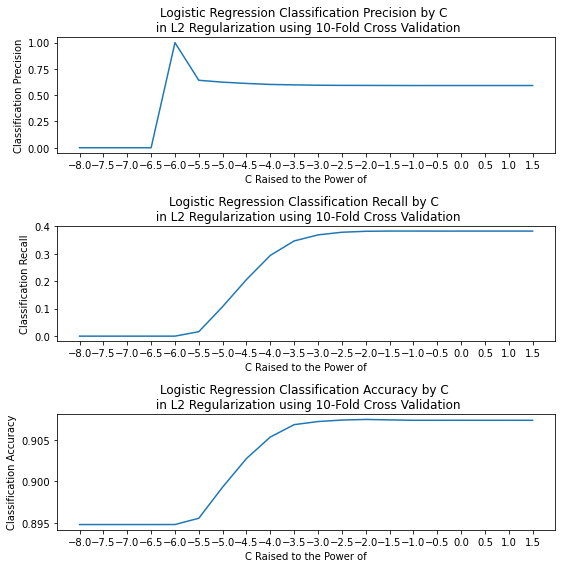

In [63]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(8, 8)
ax[0].plot(np.arange(-8,2,0.5),l2_precision)
ax[0].set_title("Logistic Regression Classification Precision by C \n in L2 Regularization using 10-Fold Cross Validation")
ax[0].set_xlabel("C Raised to the Power of")
ax[0].set_ylabel("Classification Precision")
ax[0].set_xticks(np.arange(-8,2,0.5))
ax[1].plot(np.arange(-8,2,0.5),l2_recall)
ax[1].set_title("Logistic Regression Classification Recall by C \n in L2 Regularization using 10-Fold Cross Validation")
ax[1].set_xlabel("C Raised to the Power of")
ax[1].set_ylabel("Classification Recall")
ax[1].set_xticks(np.arange(-8,2,0.5))
ax[2].plot(np.arange(-8,2,0.5),l2_acc)
ax[2].set_title("Logistic Regression Classification Accuracy by C \n in L2 Regularization using 10-Fold Cross Validation")
ax[2].set_xlabel("C Raised to the Power of")
ax[2].set_ylabel("Classification Accuracy")
ax[2].set_xticks(np.arange(-8,2,0.5))
fig.tight_layout()
#plt.savefig('Regularization Metrics.png')

The recall, precision, and acurracy are maximized with C being 10 raised to -2.5. When looking at the coefficient plot a few cells above, having C equal to 10 raised to -2.5 seems like the best fitting model. The accuracy metrics are shown below as well as the coefficients.

In [68]:
print("L2 Precision is "+str(l2_precision[11]))
print("L2 Recall is "+str(l2_recall[11]))
print("L2 Accuracy is "+str(l2_acc[11]))

L2 Precision is 0.5935978358881876
L2 Recall is 0.37819748653500895
L2 Accuracy is 0.9073618343628813


## Logistic Regression Summary Metrics

In [69]:
model_names = ['Forward Selection','Backward Selection','L2 Regularization']
accuracies = [fwd_final_acc[0],bwd_acc[4],l2_acc[11]]
recalls = [fwd_final_recall[0],bwd_recall[4],l2_recall[11]]
precisions = [fwd_final_precision[0],bwd_precision[4],l2_precision[11]]
log_summary = pd.DataFrame({'Model Type':model_names,'Accuracy':accuracies,'Precision':precisions,'Recall':recalls})
log_summary

,Model Type,Accuracy,Precision,Recall
0,Forward Selection,0.907242,0.597784,0.361092
1,Backward Selection,0.907738,0.595481,0.383066
2,L2 Regularization,0.907362,0.593598,0.378197


# Building Decision Tree Models

I would like to loop through the different number of leaf nodes to see what the minimum complexity is to obtain maximum accuracy. I will use 5-fold cross validation to achieve this.

In [70]:
#decision trees should not contain interaction terms since the nature of decision trees considers them. Therfore, I'll
#create a new X space for non interactions
X_tree = X[['Pneumonia','Pregnant','Diabetes','COPD Diagnosis','Asthma','Immunosuppression','Hypertension','Other Diseases',
           'Cardiovascular Disease','Obesity','Kidney Failure','Smoker','New Age','Total Factors','Entity Group_1',
           'Entity Group_2','Entity Group_3','Sex_1','Sex_2']]
X_tree_test = X_test[['Pneumonia','Pregnant','Diabetes','COPD Diagnosis','Asthma','Immunosuppression','Hypertension','Other Diseases',
           'Cardiovascular Disease','Obesity','Kidney Failure','Smoker','New Age','Total Factors','Entity Group_1',
           'Entity Group_2','Entity Group_3','Sex_1','Sex_2']]

In [ ]:
tree_metrics = []
for i in range(2,30):
    covid_tree = tree.DecisionTreeClassifier(max_leaf_nodes=i)
    tree_metric = utils.performValidations(X_tree,y,[list(X_tree.columns)],5,covid_tree)
    tree_metrics.append(tree_metric[0])

In [73]:
tree_precision, tree_recall, tree_acc = utils.getMetricSummaries(tree_metrics)

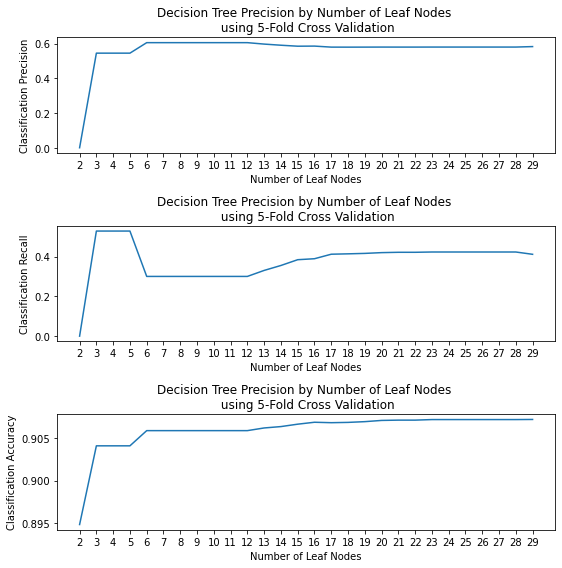

In [74]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(8, 8)
ax[0].plot(np.arange(2,30,1),tree_precision)
ax[0].set_title("Decision Tree Precision by Number of Leaf Nodes \n using 5-Fold Cross Validation")
ax[0].set_xlabel("Number of Leaf Nodes")
ax[0].set_ylabel("Classification Precision")
ax[0].set_xticks(np.arange(2,30,1))
ax[1].plot(np.arange(2,30,1),tree_recall)
ax[1].set_title("Decision Tree Precision by Number of Leaf Nodes \n using 5-Fold Cross Validation")
ax[1].set_xlabel("Number of Leaf Nodes")
ax[1].set_ylabel("Classification Recall")
ax[1].set_xticks(np.arange(2,30,1))
ax[2].plot(np.arange(2,30,1),tree_acc)
ax[2].set_title("Decision Tree Precision by Number of Leaf Nodes \n using 5-Fold Cross Validation")
ax[2].set_xlabel("Number of Leaf Nodes")
ax[2].set_ylabel("Classification Accuracy")
ax[2].set_xticks(np.arange(2,30,1))
fig.tight_layout()
#plt.savefig('Tree Leaf Metrics.png')

In [75]:
print("Three leaved tree precision is "+str(tree_precision[1]))
print("Three leaved tree recall is "+str(tree_recall[1]))
print("Three leaved tree accuracy is "+str(tree_acc[1]))

Three leaved tree precision is 0.5454356907943468
Three leaved tree recall is 0.5288043087971275
Three leaved tree accuracy is 0.904083596574317


Below is the drawing of the three leaved tree.

[Text(334.8, 679.5, 'Pneumonia <= 0.5\ngini = 0.188\nsamples = 661941\nvalue = [592316, 69625]'),
 Text(167.4, 407.69999999999993, 'gini = 0.065\nsamples = 539983\nvalue = [521833, 18150]'),
 Text(502.20000000000005, 407.69999999999993, 'New Age <= 0.575\ngini = 0.488\nsamples = 121958\nvalue = [70483, 51475]'),
 Text(334.8, 135.89999999999998, 'gini = 0.39\nsamples = 53274\nvalue = [39114, 14160]'),
 Text(669.6, 135.89999999999998, 'gini = 0.496\nsamples = 68684\nvalue = [31369, 37315]')]

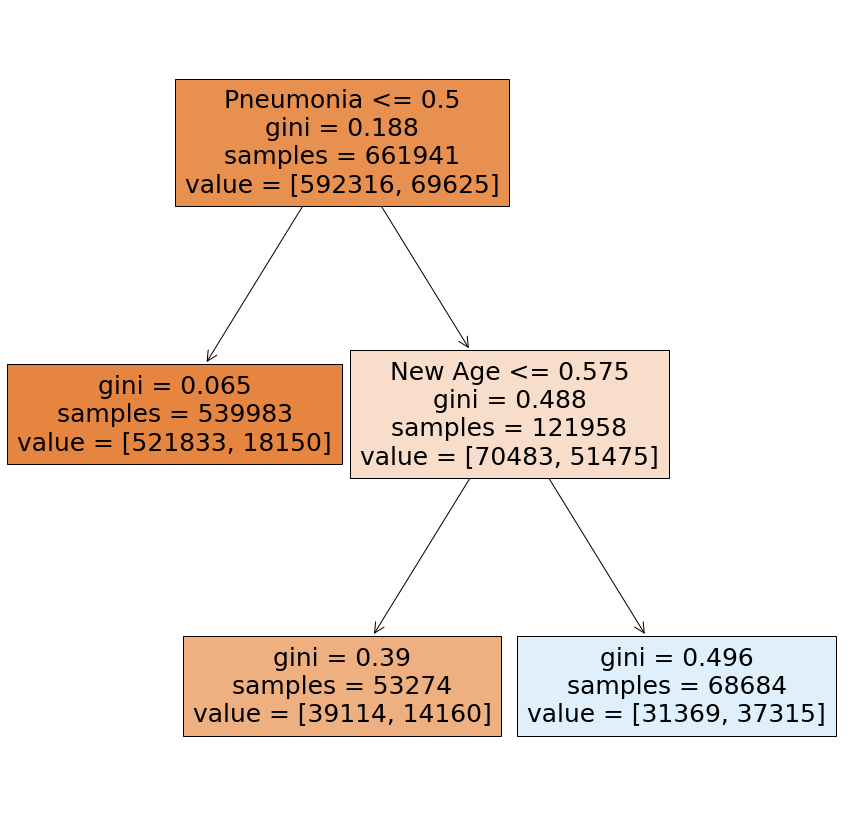

In [76]:
covid_tree_3 = tree.DecisionTreeClassifier(max_leaf_nodes=3)
covid_tree_3.fit(X_tree,y)
fig = plt.figure(figsize= (15,15))
tree.plot_tree(covid_tree_3,
   feature_names= X_tree.columns,
   filled=True)

## Pruning the Tree

These cells explore the addition of a term to the cost function of the decision trees that will penalize trees more and more as their complexity increases.

In [82]:
#first using the cost_complexity_pruning_path from sklearn
covid_tree = tree.DecisionTreeClassifier(random_state=0)
pruning = covid_tree.cost_complexity_pruning_path(X_tree,y)
ccp_alphas, impurities = pruning.ccp_alphas, pruning.impurities

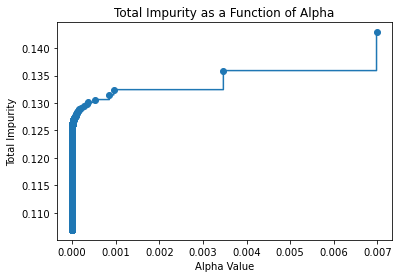

In [83]:
fig,ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("Alpha Value")
ax.set_ylabel("Total Impurity")
ax.set_title("Total Impurity as a Function of Alpha")
#fig.savefig('Tree_Pruning_Impurities')

In [84]:
#create a list of trees for each increment - these will be used for depth plots
covid_trees = []
for v in np.arange(0,.007,.0005):
    covid_tree = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=max(0,v))
    covid_tree.fit(X_tree, y)
    covid_trees.append(covid_tree)

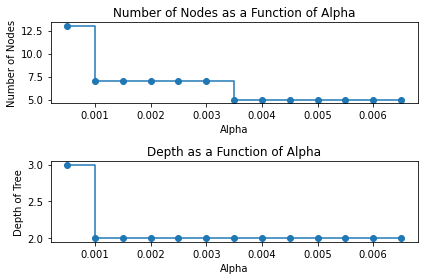

In [85]:
ccp_alphas = np.arange(0,.007,.0005)
node_counts = [covid_tree.tree_.node_count for covid_tree in covid_trees]
depth = [covid_tree.tree_.max_depth for covid_tree in covid_trees]

fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas[1:], node_counts[1:], marker='o', drawstyle="steps-post")
ax[0].set_xlabel("Alpha")
ax[0].set_ylabel("Number of Nodes")
ax[0].set_title("Number of Nodes as a Function of Alpha")
ax[1].plot(ccp_alphas[1:], depth[1:], marker='o', drawstyle="steps-post")
ax[1].set_xlabel("Alpha")
ax[1].set_ylabel("Depth of Tree")
ax[1].set_title("Depth as a Function of Alpha")
fig.tight_layout()
#fig.savefig('Pruning_Tree_Sizes.png')

In [ ]:
#now to go through each ccp_alpha (incremented by 0.001 this time) and then do k-fold cross validation in 
#order to get estimated test error rate and then select the ccp_alpha that yields the best test_accuracy
ccp_alphas_testing = np.arange(0,.007,.0005)
prune_metrics = []
for v in ccp_alphas_testing:
    covid_tree = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=v)
    prune_metric = utils.performValidations(X_tree,y,[list(X_tree.columns)],5,covid_tree)
    prune_metrics.append(prune_metric[0])

In [90]:
prune_precision, prune_recall, prune_acc = utils.getMetricSummaries(prune_metrics)

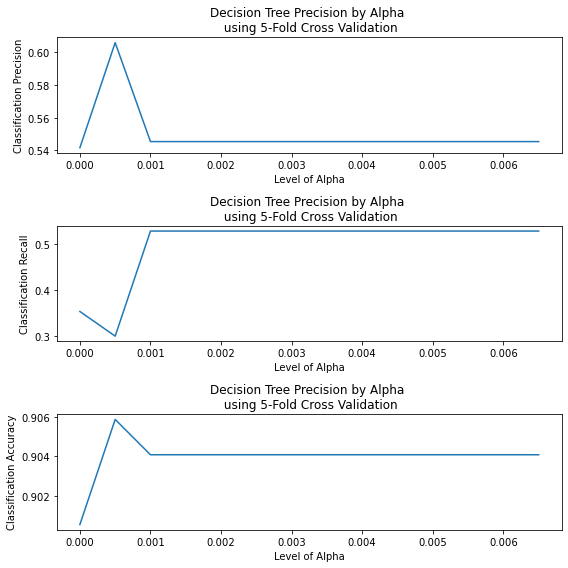

In [91]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(8, 8)
ax[0].plot(np.arange(0,0.007,.0005),prune_precision)
ax[0].set_title("Decision Tree Precision by Alpha \n using 5-Fold Cross Validation")
ax[0].set_xlabel("Level of Alpha")
ax[0].set_ylabel("Classification Precision")
ax[1].plot(np.arange(0,.007,.0005),prune_recall)
ax[1].set_title("Decision Tree Precision by Alpha \n using 5-Fold Cross Validation")
ax[1].set_xlabel("Level of Alpha")
ax[1].set_ylabel("Classification Recall")
ax[2].plot(np.arange(0,.007,.0005),prune_acc)
ax[2].set_title("Decision Tree Precision by Alpha \n using 5-Fold Cross Validation")
ax[2].set_xlabel("Level of Alpha")
ax[2].set_ylabel("Classification Accuracy")
fig.tight_layout()
#plt.savefig('Tree Prune Metrics.png')

In [92]:
print("Pruned Tree Precision is "+str(prune_precision[2]))
print("Pruned Tree Recall is "+str(prune_recall[2]))
print("Pruned Tree Accuracy is "+str(prune_acc[2]))

Pruned Tree Precision is 0.5454356907943468
Pruned Tree Recall is 0.5288043087971275
Pruned Tree Accuracy is 0.904083596574317


I have chosen an alpha value of 0.001 because this is where the complexity of the tree and the impurity starts to flatten out. Also, the estimated test metrics are maximized here. Below is the drawing of the tree chosen from cost complexity pruning.

[Text(418.5, 679.5, 'Pneumonia <= 0.5\ngini = 0.188\nsamples = 661941\nvalue = [592316, 69625]'),
 Text(209.25, 407.69999999999993, 'New Age <= 1.187\ngini = 0.065\nsamples = 539983\nvalue = [521833, 18150]'),
 Text(104.625, 135.89999999999998, 'gini = 0.037\nsamples = 488382\nvalue = [479285, 9097]'),
 Text(313.875, 135.89999999999998, 'gini = 0.289\nsamples = 51601\nvalue = [42548, 9053]'),
 Text(627.75, 407.69999999999993, 'New Age <= 0.575\ngini = 0.488\nsamples = 121958\nvalue = [70483, 51475]'),
 Text(523.125, 135.89999999999998, 'gini = 0.39\nsamples = 53274\nvalue = [39114, 14160]'),
 Text(732.375, 135.89999999999998, 'gini = 0.496\nsamples = 68684\nvalue = [31369, 37315]')]

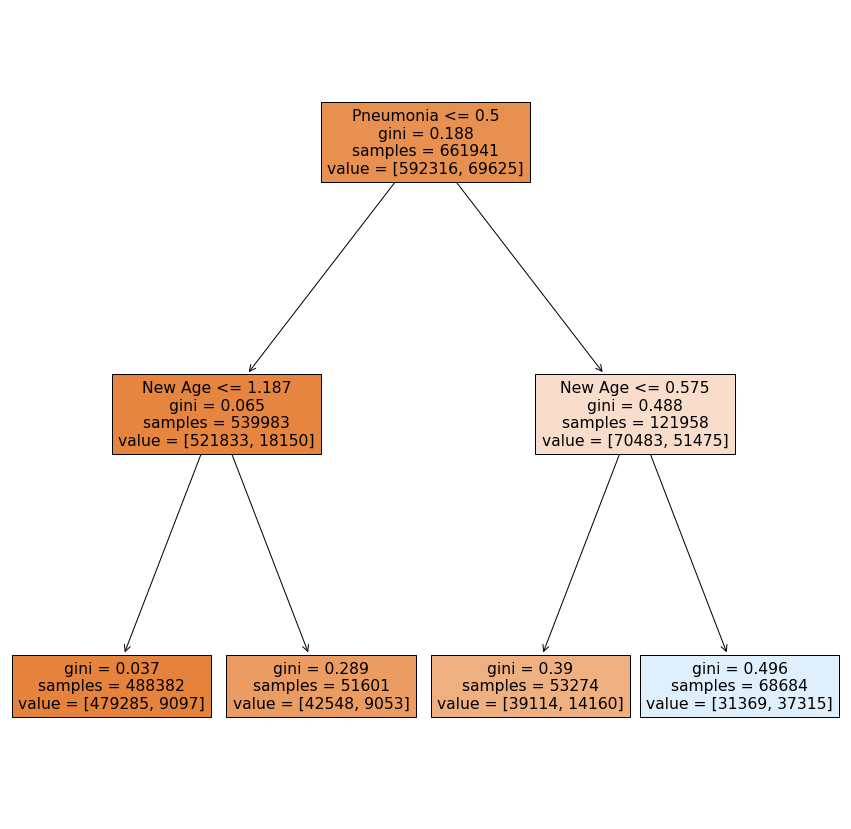

In [93]:
#showing the pruned tree of choice
covid_tree_pruned = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=0.001)
covid_tree_pruned.fit(X_tree,y)
fig = plt.figure(figsize= (15,15))
tree.plot_tree(covid_tree_pruned,
   feature_names= X_tree.columns,
   filled=True)

# Random Forest Modelling

Due to the high variance of stand alone trees, Random Forest seems like a logical model to test as well. In addition, Pneumonia has been a very strong feature in all of the models so far, so I am curious to see how the random forest will perform since not all trees will be exposed to the Pneumonia feature.

In [ ]:
rf15_metrics = []
for i in range(1,526,25):
    rf = RandomForestClassifier(n_estimators=i, max_leaf_nodes = 15, max_features= 4)
    metric = utils.performValidations(X_tree,y,[X_tree.columns],3,rf)
    rf15_metrics.append(metric[0])

In [ ]:
#loop through to see how many estimators are actually necessary
rf_round2_metrics = []
for i in range(1,526,25):
    rf = RandomForestClassifier(n_estimators=i, max_leaf_nodes = 10, max_features= 4)
    metric = utils.performValidations(X_tree,y,[X_tree.columns],3,rf)
    rf_round2_metrics.append(metric[0])

In [114]:
rf_15_precision, rf_15_recall, rf_15_acc = utils.getMetricSummaries(rf15_metrics)
rf_10_precision, rf_10_recall, rf_10_acc = utils.getMetricSummaries(rf_round2_metrics)

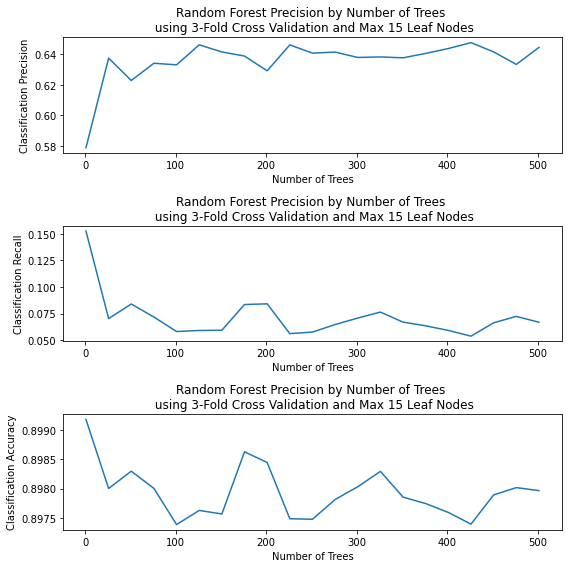

In [115]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(8, 8)
ax[0].plot(np.arange(1,526,25),rf_15_precision)
ax[0].set_title("Random Forest Precision by Number of Trees \n using 3-Fold Cross Validation and Max 15 Leaf Nodes")
ax[0].set_xlabel("Number of Trees")
ax[0].set_ylabel("Classification Precision")
ax[1].plot(np.arange(1,526,25),rf_15_recall)
ax[1].set_title("Random Forest Precision by Number of Trees \n using 3-Fold Cross Validation and Max 15 Leaf Nodes")
ax[1].set_xlabel("Number of Trees")
ax[1].set_ylabel("Classification Recall")
ax[2].plot(np.arange(1,526,25),rf_15_acc)
ax[2].set_title("Random Forest Precision by Number of Trees \n using 3-Fold Cross Validation and Max 15 Leaf Nodes")
ax[2].set_xlabel("Number of Trees")
ax[2].set_ylabel("Classification Accuracy")
fig.tight_layout()
plt.savefig('Random Forest 15 Metrics.png')

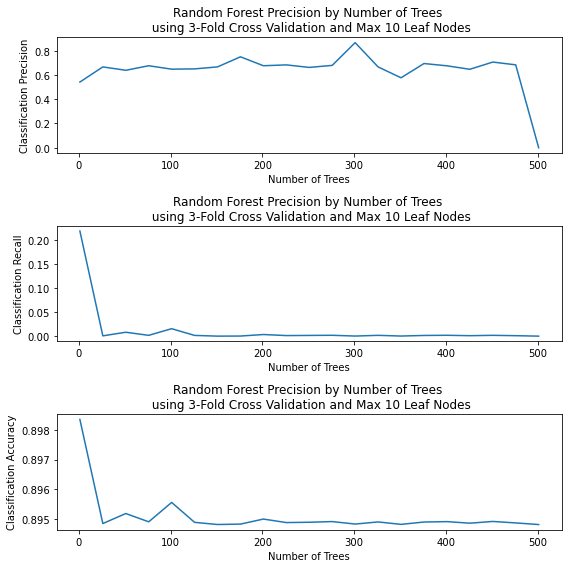

In [116]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(8, 8)
ax[0].plot(np.arange(1,526,25),rf_10_precision)
ax[0].set_title("Random Forest Precision by Number of Trees \n using 3-Fold Cross Validation and Max 10 Leaf Nodes")
ax[0].set_xlabel("Number of Trees")
ax[0].set_ylabel("Classification Precision")
ax[1].plot(np.arange(1,526,25),rf_10_recall)
ax[1].set_title("Random Forest Precision by Number of Trees \n using 3-Fold Cross Validation and Max 10 Leaf Nodes")
ax[1].set_xlabel("Number of Trees")
ax[1].set_ylabel("Classification Recall")
ax[2].plot(np.arange(1,526,25),rf_10_acc)
ax[2].set_title("Random Forest Precision by Number of Trees \n using 3-Fold Cross Validation and Max 10 Leaf Nodes")
ax[2].set_xlabel("Number of Trees")
ax[2].set_ylabel("Classification Accuracy")
fig.tight_layout()
plt.savefig('Random Forest 10 Metrics.png')

None of these random forests seemed to have performed well. The forest with 15 leaf nodes per tree performed best when using only 176 trees to create it. However, I think that the performance when using 176 trees was a luck of the draw, because as the number of trees increases, the accuracy converges to a lower figure than found using 176 trees. However, since I don't think the random forest worked well on this data, I will compare the metrics from this random forest with 176 trees to show that even with a best case scenario, the random forest underperformed. This forests metrics can be seen below.

In [117]:
print("15 Leaf Node Random Forest Precision is "+str(rf_15_precision[7]))
print("15 Leaf Node Random Forest Recall is "+str(rf_15_recall[7]))
print("15 Leaf Node Random Forest Accuracy is "+str(rf_15_acc[7]))

15 Leaf Node Random Forest Precision is 0.638751511155072
15 Leaf Node Random Forest Recall is 0.08347576301615799
15 Leaf Node Random Forest Accuracy is 0.8986314490264238


## Decision Tree Summary Metrics

In [128]:
#creating a dataframe that has all the tree metrics
tree_names = ['Three Leaved Tree','Pruned Tree','Random Forest']
accuracies = [tree_acc[1],prune_acc[2],rf_15_acc[7]]
recalls = [tree_recall[1],prune_recall[2],rf_15_recall[7]]
precisions = [tree_precision[1],prune_precision[2],rf_15_precision[7]]
tree_summary = pd.DataFrame({'Model Type':tree_names,'Accuracy':accuracies,'Precision':precisions,'Recall':recalls})
tree_summary

,Model Type,Accuracy,Precision,Recall
0,Three Leaved Tree,0.904084,0.545436,0.528804
1,Pruned Tree,0.904084,0.545436,0.528804
2,Random Forest,0.898631,0.638752,0.083476


# Comparing All Models

### Comparison of Accuracy, Precision, and Recall

In [ ]:
#so far, I only have the mean of each metric, so I also need to get the standard deviation
#fwd selection
stds = []
log_model = LogisticRegression(penalty = 'none', max_iter= 10000)
cv_fivefold = cross_validate(estimator = log_model, X=X[chosen_fwd_features], y=y, cv = 5,
                             n_jobs=-1, return_train_score=True,return_estimator=True, 
                             verbose = 2)
stds.append(cv_fivefold['test_score'].std())

#bwd selection
cv_fivefold = cross_validate(estimator = log_model, X=X[bwd_models[4]], y=y, cv = 5,
                             n_jobs=-1, return_train_score=True,return_estimator=True, 
                             verbose = 2)
stds.append(cv_fivefold['test_score'].std())

#l2 regularization
l2_log = LogisticRegression(penalty = 'l2',C=10**(-2.5),max_iter=10000)
cv_fivefold = cross_validate(estimator = l2_log, X=X, y=y, cv = 5,
                             n_jobs=-1, return_train_score=True,return_estimator=True, 
                             verbose = 2)
stds.append(cv_fivefold['test_score'].std())

#three leaved tree
covid_tree_3 = tree.DecisionTreeClassifier(max_leaf_nodes=3)
cv_fivefold = cross_validate(estimator = covid_tree_3, X=X, y=y, cv = 5,
                             n_jobs=-1, return_train_score=True,return_estimator=True, 
                             verbose = 2)
stds.append(cv_fivefold['test_score'].std())

#pruned tree
covid_tree_pruned = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=0.001)
cv_fivefold = cross_validate(estimator = covid_tree_pruned, X=X, y=y, cv = 5,
                             n_jobs=-1, return_train_score=True,return_estimator=True, 
                             verbose = 2)
stds.append(cv_fivefold['test_score'].std())

#random forest
rf = RandomForestClassifier(n_estimators=176, max_leaf_nodes = 15, max_features= 4)
cv_fivefold = cross_validate(estimator = rf, X=X, y=y, cv = 3,
                             n_jobs=-1, return_train_score=True,return_estimator=True, 
                             verbose = 2)
stds.append(cv_fivefold['test_score'].std())

In [125]:
#concatenate the log_summary to the tree_summary to get a grand summary dataframe
grand_summary = pd.concat([log_summary,tree_summary])
grand_summary['Accuracy Std'] = stds

In [126]:
grand_summary

,Model Type,Accuracy,Precision,Recall,Accuracy Std
0,Forward Selection,0.907242,0.597784,0.361092,5.453823e-04
1,Backward Selection,0.907738,0.595481,0.383066,6.230909e-04
2,L2 Regularization,0.907362,0.593598,0.378197,6.415157e-04
0,Three Leaved Tree,0.904084,0.545436,0.528804,3.178006e-07
1,Pruned Tree,0.904084,0.545436,0.528804,6.002595e-04
2,Random Forest,0.898631,0.638752,0.083476,4.469809e-04


### Comparison of the AUC for each model

In [132]:
AUCs = []
names = ['Forward Selection Logistic Regression Model','Backward Selection Logistic Regression Model','L2 Regularization Logistic Regression Model',
        'Three Leaved Decision Tree','Pruned Decision Tree','Random Forest']
#forward selection log model
log_model = LogisticRegression(penalty = 'none', max_iter= 10000)
y_scores_fwd = cross_val_predict(log_model,X[chosen_fwd_features],y,cv=5,method='predict_proba')
y_scores_fwd = [item[1] for item in y_scores_fwd]
fpr_fwd, tpr_fwd, thresholds_fwd = roc_curve(y,y_scores_fwd)
AUCs.append(roc_auc_score(y,y_scores_fwd))

#backward selection log model
log_model = LogisticRegression(penalty = 'none', max_iter= 10000)
y_scores_bwd = cross_val_predict(log_model,X[bwd_models[4]],y,cv=5,method='predict_proba')
y_scores_bwd = [item[1] for item in y_scores_bwd]
fpr_bwd, tpr_bwd, thresholds_bwd = roc_curve(y,y_scores_bwd)
AUCs.append(roc_auc_score(y,y_scores_bwd))

#L2 regularization log model
l2_log = LogisticRegression(penalty = 'l2',C=10**(-2.5),max_iter=10000)
y_scores_l2 = cross_val_predict(l2_log,X,y,cv=5,method='predict_proba')
y_scores_l2 = [item[1] for item in y_scores_l2]
fpr_l2, tpr_l2, thresholds_l2 = roc_curve(y,y_scores_l2)
AUCs.append(roc_auc_score(y,y_scores_l2))

#three leaved tree
covid_tree_3 = tree.DecisionTreeClassifier(max_leaf_nodes=3)
y_scores_3 = cross_val_predict(covid_tree_3,X_tree,y,cv=5,method='predict_proba')
y_scores_3 = [item[1] for item in y_scores_3]
fpr_3, tpr_3, thresholds_3 = roc_curve(y,y_scores_3)
AUCs.append(roc_auc_score(y,y_scores_3))

#pruned tree
covid_tree_pruned = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=0.001)
y_scores_pruned = cross_val_predict(covid_tree_pruned,X_tree,y,cv=5,method='predict_proba')
y_scores_pruned = [item[1] for item in y_scores_pruned]
fpr_pruned, tpr_pruned, thresholds_pruned = roc_curve(y,y_scores_pruned)
AUCs.append(roc_auc_score(y,y_scores_pruned))

#random forest
rf_500_10 = RandomForestClassifier(n_estimators=500, max_leaf_nodes = 10, max_features= 4)
y_scores_rf = cross_val_predict(rf_500_10,X_tree,y,cv=5,method='predict_proba')
y_scores_rf = [item[1] for item in y_scores_rf]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y,y_scores_rf)
AUCs.append(roc_auc_score(y,y_scores_rf))

grand_summary['AUCs'] = AUCs

In [133]:
grand_summary

,Model Type,Accuracy,Precision,Recall,Accuracy Std,AUCs
0,Forward Selection,0.907242,0.597784,0.361092,5.453823e-04,0.912943
1,Backward Selection,0.907738,0.595481,0.383066,6.230909e-04,0.910598
2,L2 Regularization,0.907362,0.593598,0.378197,6.415157e-04,0.914667
0,Three Leaved Tree,0.904084,0.545436,0.528804,3.178006e-07,0.821973
1,Pruned Tree,0.904084,0.545436,0.528804,6.002595e-04,0.874612
2,Random Forest,0.898631,0.638752,0.083476,4.469809e-04,0.909334


Based on the above summary, the backward selection model looks the best. It has the highest estimated accuracy and has a precision close the highest among the other models and has the highest recall of the logistic regression models. Even though the decision trees had better recall and comparable accuracy, their precision was not as good, and the AUCs are a few points below. Another advantage of the backward model compared to other logistic regression models is that it is simpler.

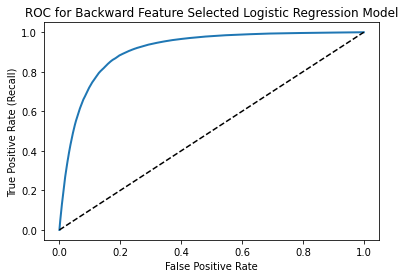

<Figure size 432x288 with 0 Axes>

In [143]:
#making a plot of the ROC curve of the backward feature selected logistic regression model.
plt.plot(fpr_bwd, tpr_bwd, linewidth=2)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC for Backward Feature Selected Logistic Regression Model")
plt.show()

## Evaluating the Precision Recall Tradeoff for the Chosen Model

In [140]:
bwd_precisions, bwd_recalls, thresholds_bwd = precision_recall_curve(y, y_scores_bwd)

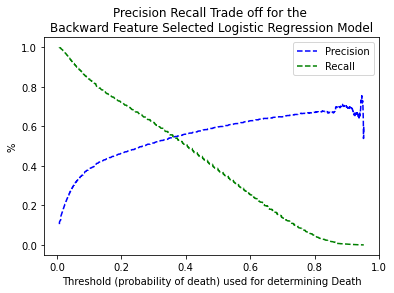

In [141]:
plt.plot(thresholds_bwd, bwd_precisions[:-1],'b--',label='Precision')
plt.plot(thresholds_bwd, bwd_recalls[:-1],'g--',label='Recall')
plt.legend()
plt.xlabel("Threshold (probability of death) used for determining Death")
plt.ylabel("%")
plt.title("Precision Recall Trade off for the \nBackward Feature Selected Logistic Regression Model")
plt.show()

The above precision recall curve shows that we can raise and lower the precision and recall (inversely of course) by revising the probability cutoff for classification.

# Testing the chosen model on the Test Data

In [146]:
#training the model with the full training data
log_model = LogisticRegression(penalty = 'none', max_iter= 10000)
log_model.fit(X[bwd_models[4]],y)

LogisticRegression(max_iter=10000, penalty='none')

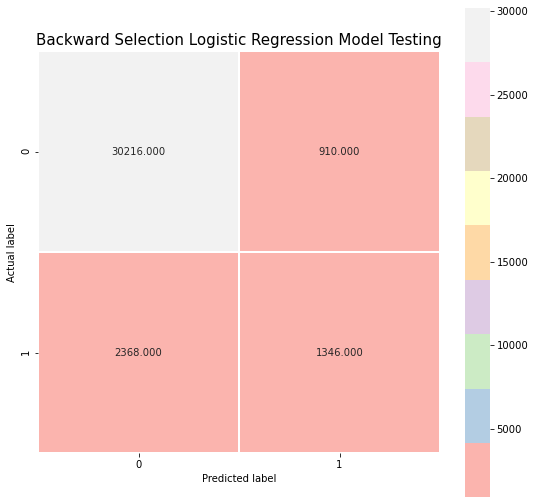

Accuracy = 0.9059127439724455
Precision = 0.5966312056737588
Recall = 0.362412493268713


In [147]:
#creating predictions of the test data
predictions = log_model.predict(X_t[bwd_models[4]])

#getting the test metrics
cm = metrics.confusion_matrix(y_t, predictions)

#deriving the accuracy, precision, and recall
test_acc = (cm[0][0]+cm[1][1])/(sum(cm[0])+sum(cm[1]))
test_prec = cm[1][1]/(cm[1][1]+cm[0][1])
test_rec = cm[1][1]/(cm[1][0]+cm[1][1])
#plotting the metrics
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Pastel1');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Backward Selection Logistic Regression Model Testing", size = 15);
plt.show()

print("Accuracy = " +str(test_acc))
print("Precision = "+str(test_prec))
print("Recall = "+str(test_rec))

The test metrics are slightly lower than those estimated using 5-fold cross validation.